# Visualizing results of onine meta analyses of the same topic

I searched for the term "decision making" in these two websites, and downloaded the results:
- NeuroSynth: https://neuroquery.saclay.inria.fr/ 
- NeuroQuery: https://neuroquery.saclay.inria.fr/ 


In [1]:
import warnings
warnings.filterwarnings("ignore")
import functions as fun # functions mostly written by Alexendre Perez
from nistats import thresholding
import numpy as np
import nibabel as nib
import nibabel.processing
import nilearn
from nilearn import masking, plotting, image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as st
from netneurotools import stats as nnstats
from netneurotools import datasets as nndata

template = nilearn.datasets.load_mni152_template()
affine = template.affine

level = .05
height_control = 'fdr'
cluster_threshold = 1
sample_size=119

%matplotlib inline
cut_coords=(0, 0, 0)
save_figs = False

hypothesis = 1

## Get data paths and threshold maps

In [2]:
# NEUROQUERY
NQ_path = '../data-narps/NQ_loss_aversion_in_decisionmaking_under_risk.nii.gz'
NQ_t = thresholding.map_threshold(NQ_path, alpha=level,
                               height_control=height_control,
                               cluster_threshold=cluster_threshold)[0]

# LEVEL-3 META-ANALYTIC RESULT
L3_path = '../data-narps/results1_hypo%d_Level-3-t-map.nii.gz' %hypothesis
L3_t = '../data-narps/results1_hypo%d_Level-3-t-map---thresholded.nii.gz' %hypothesis

# LEVEL-2 RESULTS
L2s_path = fun.get_data_paths_from_orig('hypo%d_unthresh.nii.gz' %hypothesis)

N_img = 5
L2s_path = L2s_path[:N_img]

## Convert volumes to surfaces 
So that the spin test can be used to test the significance of the similarity between maps (the spin test works on surfaces)

In [3]:
# sample the 3D volume data onto a surface mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage('fsaverage5') #('fsaverage') # cortical mesh

from nilearn import surface
def get_surface(vol_path, hemi):
    if hemi == 'left': surf_mesh = fsaverage.pial_left
    if hemi == 'right': surf_mesh = fsaverage.pial_right
    surf = surface.vol_to_surf(img=vol_path, surf_mesh=surf_mesh, mask_img=template)
    surf = np.nan_to_num(surf, nan=0)
    if len(surf.shape) < 2: surf = np.expand_dims(np.array(surf), axis=1)
    return surf
    
# level-3 results
L3_L = get_surface(L3_path, hemi='left')
L3_R = get_surface(L3_path, hemi='right')

# neuroquery results
NQ_L = get_surface(NQ_path, hemi='left')
NQ_R = get_surface(NQ_path, hemi='right')

# level-2 results
for n, path in enumerate(L2s_path):
    L = get_surface(path, hemi='left')
    R = get_surface(path, hemi='right')
    if n == 0:
        L2s_L = L
        L2s_R = R
        vertex = np.argmax(L) # for selecting vertices to plot
    else:
        L2s_L = np.concatenate((L, L2s_L), axis=1)
        L2s_R = np.concatenate((R, L2s_R), axis=1)

## Measure similarity

### Similarity between level-3 results & NeuroQuery results

In [4]:
# concatenate hemispheres
L3 = np.concatenate((L3_R, L3_L), axis=0)
NQ = np.concatenate((NQ_R, NQ_L), axis=0)

# whole brain
rs_NQ_L3 = st.spearmanr(a=NQ, b=L3, axis=0, nan_policy='omit')[0]

# hemispheres separate
rs_NQ_L3_L = st.spearmanr(a=NQ_L, b=L3_L, axis=0, nan_policy='omit')[0]
rs_NQ_L3_R = st.spearmanr(a=NQ_R, b=L3_R, axis=0, nan_policy='omit')[0]

# results
print(rs_NQ_L3, rs_NQ_L3_L, rs_NQ_L3_R)

0.17705008268187633 0.17170031058287497 0.17729523115521048


#### Visualize similarity

Text(0.5, 1.0, '$R_{spearman}$ = 0.177050')

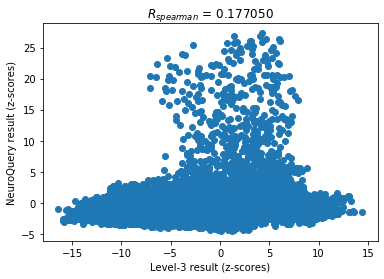

In [5]:
plt.scatter(L3, NQ)
plt.xlabel('Level-3 result (z-scores)')
plt.ylabel('NeuroQuery result (z-scores)')
plt.title('$R_{spearman}$ = %f' %rs_NQ_L3)

#### Significance of similarity

First, we'll grab the spherical projections of the fsaverage6 surface and extract the vertex coordinates:

In [6]:
import nibabel as nib

# if you have FreeSurfer installed on your computer this will simply grab the
# relevant files from the $SUBJECTS_DIR directory; otherwise, it will download
# them to the $HOME/nnt-data/tpl-fsaverage directory
lhsphere, rhsphere = nndata.fetch_fsaverage('fsaverage5', verbose=0)['sphere']
lhvert, lhface = nib.freesurfer.read_geometry(lhsphere)
rhvert, rhface = nib.freesurfer.read_geometry(rhsphere)

Then, we'll provide these to the function for generating the spin-based resampling array. We also need an indicator array designating which coordinates belong to which hemisphere so we'll create that first:

In [7]:
coords = np.vstack([lhvert, rhvert])
hemi = [0] * len(lhvert) + [1] * len(rhvert)
spins, cost = nnstats.gen_spinsamples(coords, hemi, n_rotate=10, seed=1234)
print(spins.shape)
print(spins)

(20484, 10)
[[10085  2792  2813 ...   152  2778  8691]
 [ 2715  2805  2201 ...  5982  3714  5015]
 [ 8411  5802  4997 ...  4935  5188  5801]
 ...
 [10972 10594 10820 ... 12874 11585 19898]
 [10972 17395 15521 ... 12874 15712 19897]
 [14335 11657 15522 ... 12872 17270 10684]]


Then, we'll provide these to the function for generating the spin-based resampling array. We also need an indicator array designating which coordinates belong to which hemisphere so we'll create that first:

In [8]:
for rotation in range(10):
    uniq = len(np.unique(spins[:, rotation]))
    print('Rotation {:>2}: {} vertices' #, {:.2f} mm / vertex'
          .format(rotation + 1, uniq)) #, cost[rotation] / len(spins)))

Rotation  1: 18880 vertices
Rotation  2: 19022 vertices
Rotation  3: 18986 vertices
Rotation  4: 18911 vertices
Rotation  5: 18954 vertices
Rotation  6: 18872 vertices
Rotation  7: 18830 vertices
Rotation  8: 18906 vertices
Rotation  9: 19014 vertices
Rotation 10: 19310 vertices


In [9]:
cost[rotation]

array([1.89020219, 1.60799861, 0.83718874, 2.04336824, 2.0150525 ,
       1.83675594, 1.11516904, 1.29755506, 0.99803089, 1.26752999])

### Similarity between level-2 results & NeuroQuery results, for each analysis team

In [10]:
rp2_teams_nq = []
rs2_teams_nq = []

rp_teams_nq = []
rs_teams_nq = []
for team_ds_data in narps_ds_data:
    rp = np.corrcoef(team_ds_data.flatten(), nq_data.flatten())[0,1]
    rp_teams_nq.append(rp)
    rp2_teams_nq.append(rp * rp)
    
    rs = st.spearmanr(a=team_ds_data.flatten(), b=nq_data.flatten(), nan_policy='omit', axis=1)[0]
    rs_teams_nq.append(rs)
    rs2_teams_nq.append(rs*rs)

NameError: name 'narps_ds_data' is not defined

In [ ]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(L2s_L.T[:, vertex:vertex+200])
#plt.colorbar()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.title('Level-2 maps')
plt.xlabel('Vertices (subset)')
plt.ylabel('Analysis teams')

In [ ]:
plotting.plot_surf_stat_map(surf_mesh=fsaverage.infl_right, 
                            stat_map=NQ_L, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=None, bg_map=fsaverage.sulc_right)

## Measure similarity

### Get results maps

#### NeuroQuery results

In [ ]:
nq = nilearn.image.load_img(NQ_path)
nq_data = nq.get_fdata()

#### Meta-analytic results
The voxels are different sizes, so first we need to downsample our meta-analytic result

In [ ]:
ma = nilearn.image.load_img(L3_path)
ma_downsampled = image.resample_to_img(ma, nq)
ma_ds_data = ma_downsampled.get_fdata()

#### Results from each analysis team

In [ ]:
narps_ds_data = []
for path in L2s_path:
    img = nilearn.image.load_img(path)
    img_downsampled = image.resample_to_img(img, nq)
    narps_ds_data.append(img_downsampled.get_fdata())

### Similarity between meta-analytic result and NeuroQuery result

In [ ]:
#pearson's
rp_ma_nq = np.corrcoef(ma_ds_data.flatten(), nq_data.flatten())[0,1]
rp2_ma_nq = rp_ma_nq * rp_ma_nq

# spearman's
rs_ma_nq = st.spearmanr(a=ma_ds_data.flatten(), b=nq_data.flatten(), nan_policy='omit', axis=1)[0]
rs2_ma_nq = rs_ma_nq*rs_ma_nq

### Pairwise similarity between each team's result and the NeuroQuery result

In [ ]:
rp2_teams_nq = []
rs2_teams_nq = []

rp_teams_nq = []
rs_teams_nq = []
for team_ds_data in narps_ds_data:
    rp = np.corrcoef(team_ds_data.flatten(), nq_data.flatten())[0,1]
    rp_teams_nq.append(rp)
    rp2_teams_nq.append(rp * rp)
    
    rs = st.spearmanr(a=team_ds_data.flatten(), b=nq_data.flatten(), nan_policy='omit', axis=1)[0]
    rs_teams_nq.append(rs)
    rs2_teams_nq.append(rs*rs)

### Visualize

In [ ]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

ma_nqs = {'Pearson correlation': rp_ma_nq,
        'Spearman correlation': rs_ma_nq}

teams_nqs = {'Pearson correlation': rp_teams_nq,
           'Spearman correlation': rs_teams_nq}

for name in ma_nqs:
    ma_nq = ma_nqs[name]
    team_nq = teams_nqs[name]
    
    fig, ax = plt.subplots(figsize=(15,5))
    plt.hist(team_nq, color='lightblue',
             label='sim(NeuroQuery results, \n level 2 results from each analasis team)')

    ax.axvline(x=ma_nq, color='red', label = 'sim(NeuroQuery results, \n level 3 meta-analytic results)')
    plt.legend()

    plt.xlim(-0.2,.2)
    plt.xlabel('$R$')
    plt.ylabel('Number of teams')
    plt.title(name)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig_name = '../figures/results2_histogram_%s_with_NQ.png' %name.replace(' ', '-')
    if save_figs: plt.savefig(fig_name)
    

## Visualize maps

In [ ]:
images = { 
    'Meta-analytic result - t-map, unthresholded' : level3_result_ut,
    'Meta-analytic result - t-map, thresholded' : level3_result_t,
    'NeuroQuery - z-map, unthresholded': neuroquery_ut,
    'NeuroQuery - z-map, thresholded': neuroquery_t,
#    'NeuroSynth association test (z-map)': neurosynth_assoc,
#    'NeuroSynth uniformity test (z-map)': neurosynth_uniform,
}


for name, img in images.items():
    plotting.plot_stat_map(img, title=name, cut_coords=cut_coords,
                          figure=plt.figure(figsize=(10,5)))  
    if save_figs: plt.savefig('../figures/results2_%s.png' %name.replace(' ', '-'))

In [ ]:
neuroquery_t = thresholding.map_threshold(neuroquery_ut, alpha=level,
                                           height_control=height_control,
                                           cluster_threshold=cluster_threshold)[0]

# NEUROSYNTH
#neurosynth_assoc =\
#     '../data-narps/NS_decision-making_association-test_z_FDR_0.01.nii.gz'
#neurosynth_uniform = \
#     '../data-narps/NS_decision-making_uniformity-test_z_FDR_0.01.nii.gz'

level3_result_t = '../data-narps/results1_hypo%d_Level-3-t-map---thresholded.nii.gz' %hypothesis

maps = {'NARPS level-3 map':  '../data-narps/results1_hypo%d_Level-3-t-map.nii.gz' %hypothesis,
        'NARPS level-2 maps': fun.get_data_paths_from_orig('hypo%d_unthresh.nii.gz' %hypothesis),
        'NeuroQuery result': '../data-narps/NQ_loss_aversion_in_decisionmaking_under_risk.nii.gz'  
}

In [ ]:
surfaces_L = {'NeuroQuery result - left hemisphere': [],
            'NARPS level-3 map - left hemisphere': [],
            'NARPS level-2 maps - left hemisphere': [],
}
surfaces_R = {'NeuroQuery result - right hemisphere': [],
            'NARPS level-3 map - right hemisphere': [],
            'NARPS level-2 maps - right hemisphere': [],
}

font = {'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(L2_L.T[:, vertex:vertex+200])
#plt.colorbar()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.title('Level-2 maps')
plt.xlabel('Vertices (subset)')
plt.ylabel('Analysis teams')

for team_ds_data in narps_ds_data:
    plt.figure(figsize=(10,5))
    plt.scatter(team_ds_data.flatten(), nq_data.flatten())